<a href="https://colab.research.google.com/github/JaredLevi18/Image-generator./blob/main/images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00


In [2]:
from base64 import b64encode
import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# for video display
from IPython.display import HTML
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# supress some warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
# load the autoencoder model which will be used to decode the latents (4x64x64) into image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# load the tokenizer and texr encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# the UNet model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# the noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# set everything to the gpu
vae = vae.to(device)
encoder = encoder.to(device)
unet = unet.to(device);

(…)fusion-v1-4/resolve/main/vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

(…)it-large-patch14/resolve/main/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)h14/resolve/main/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

(…)tch14/resolve/main/tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

(…)t-large-patch14/resolve/main/config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

(…)usion-v1-4/resolve/main/unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

  0%|          | 0/30 [00:00<?, ?it/s]

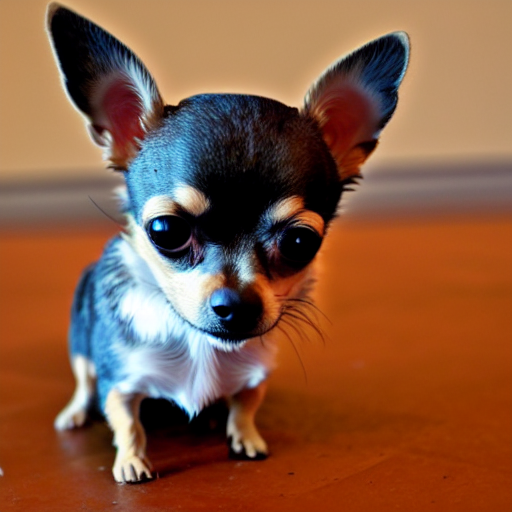

In [4]:
# settings
prompt = ["a small chihuahua"]
# width and height values are the standard for stable diffusion
height = 512
width = 512
num_inference_steps = 30   # number of denoising steps
guidance_scale = 8       # scale for classifier-free guidance
generator = torch.manual_seed(32)  # used to create the inital latent noise
batch_size = 1


# prepare text
input_text = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  embeddings = encoder(input_text.input_ids.to(device))[0]
max_length = input_text.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]
embeddings = torch.cat([uncond_embeddings, embeddings])

# prepare scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.float32)
set_timesteps(scheduler, num_inference_steps)

# prepare latents

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator
)
latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma # scaling

# diffusion loop
with autocast("cuda"):
  for i,t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    #latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predic the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
  image1 = vae.decode(latents).sample

# display
image = (image1 / 2 + 0.5).clamp(0,1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [5]:
# STEP 1: COMPUTING THE MASK

# adding noise to the input image.
def image_to_latent(image):
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(device)*2-1)
  return 0.18215 * latent.latent_dist.sample()
encoded = image_to_latent(pil_images[0])

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

start_step = 10
noise = torch.randn_like(encoded) # random noise
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
encoded_and_noised = encoded_and_noised.to(device).float()

# estimating noise conditioned to reference text and with query Q.
reference_text = ['a small chihuahua']
query_q = ['a small pitbull']
# prepare text
text_input = tokenizer(query_q, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(reference_text, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = encoder(text_input.input_ids.to(device))[0]
  text_embeddings2 = encoder(text_input2.input_ids.to(device))[0]
max_length = text_input.input_ids.shape[-1]
max_length2 = text_input2.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_input2 = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length2, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]
  uncond_embeddings2 = encoder(uncond_input2.input_ids.to(device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings2 = torch.cat([uncond_embeddings2, text_embeddings2])

for i,t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
  if i >= start_step:
    latent_model_input = torch.cat([encoded_and_noised] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
      noise_pred_query_q = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
      noise_pred_reference_text = unet(latent_model_input, t, encoder_hidden_states=text_embeddings2)["sample"]

    noise_pred_uncond, noise_pred_text = noise_pred_query_q.chunk(2)
    noise_pred_uncond2, noise_pred_text2 = noise_pred_reference_text.chunk(2)

    noised_query_q = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    noised_reference_text = noise_pred_uncond2 + guidance_scale * (noise_pred_text2 - noise_pred_uncond2)

    noise_pred = noised_query_q - noised_reference_text
    latents = scheduler.step(noise_pred, t, encoded_and_noised)

latents_to_pil(latents)[0]

  0%|          | 0/30 [00:00<?, ?it/s]

IndexError: ignored

In [7]:
??torch.cat()

Object `torch.cat()` not found.
